In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import random
import cPickle
import pylab as pl
import numpy as np
from sklearn.utils import shuffle
import textblob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

In [26]:
def clean(txt):
    not_list = ['...', 'you', 'your', 'his', 'her', 'will', "didn't", "i'll"]
    replace_list = [".", "'", '"', "!", "?", "#", "\r\n", "-", "@", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "+", "$"]
    cleaned = []
    for token in str(txt).split(' '):
        flag = False
        for y in not_list:
            if y in token.lower():
                flag = True
                break
        if flag: continue
        for y in replace_list:
            token = token.replace(y, "")
        if len(token) > 3:
            token = token.strip().lower();
            try:
                #word = textblob.TextBlob(token).words[0]
                cleaned.append(token)
            except:
                continue
    return ' '.join(cleaned).decode("ascii", "ignore")

In [27]:
def clean_pos(txt): 
    pos = TextBlob(txt).tags
    cleaned = [x[0] for x in pos if x[1] != 'IN' and x[1] != 'PRP' and x[1] != 'WP' and x[1] != 'FW']
    return ' '.join(cleaned)

In [28]:
safe_stuff = []
no_safe_stuff = []

In [49]:
safedf = pandas.DataFrame()
no_safedf = pandas.DataFrame()
messages = pandas.read_csv('./safe_recipe.csv', sep=',', quoting=csv.QUOTE_NONE,
                           names=["date", "rating", "review"])
safedf['review'] = messages[messages.columns[2:4]] 
safedf['label'] = "safe"
safedf = shuffle(safedf).reset_index(drop=True)

messages = pandas.read_csv('./no_safe_recipe.csv', sep=',', quoting=csv.QUOTE_NONE,
                           names=["date", "rating", "review"])
no_safedf['review'] = messages[messages.columns[2:4]] 
no_safedf['label'] = "not_safe"

dataset = safedf.loc[0:10000,:]
dataset = dataset.append(no_safedf.loc[0:10000,:])
print len(dataset)
dataset['review'] = dataset['review'].map(clean)
print dataset


20002
                                                  review     label
0      recipe awsome butterscotch pudding instead cup...      safe
1      super recipe kids love right even better next ...      safe
2      looking tasty lowerfat honey mustard chicken r...      safe
3      great definitly need bigger make sure spagetti...      safe
4      these really good whole disappeared last night...      safe
5      love best guacamole have ever tastedi really l...      safe
6                                                             safe
7      perfect super bowl spread quick easy definite ...      safe
8      search yahoo chocolate chip cookie recipe foun...      safe
9      star recipe have alter recipe turned fantastic...      safe
10     boyfriend said best stew ever some beef stew c...      safe
11     most favorite dishes well cook usualy dont lik...      safe
12     delicious recipe followed suggestions users di...      safe
13     wouldnt have believed that sour cream would wi...

In [50]:
dataset.replace('', np.nan, inplace=True)
dataset.dropna(subset=['review'], inplace=True)
dataset['review'] = dataset['review'].map(clean_pos)
print dataset.head()


                                              review label
0  recipe awsome butterscotch pudding instead cup...  safe
1  super recipe kids love right even better next ...  safe
2  looking tasty lowerfat honey mustard chicken r...  safe
3  great definitly need bigger make sure spagetti...  safe
4  these really good whole disappeared last night...  safe


In [51]:
dataset.groupby('label').describe()

review                       
          count unique        top freq
label                                 
not_safe   9497   8623  fantastic   14
safe       9547   9222  delicious   22

In [52]:
dataset['length'] = dataset['review'].map(lambda text: len(text))
print dataset.head()

                                              review label  length
0  recipe awsome butterscotch pudding instead cup...  safe     133
1  super recipe kids love right even better next ...  safe      58
2  looking tasty lowerfat honey mustard chicken r...  safe     123
3  great definitly need bigger make sure spagetti...  safe      65
4  these really good whole disappeared last night...  safe     125


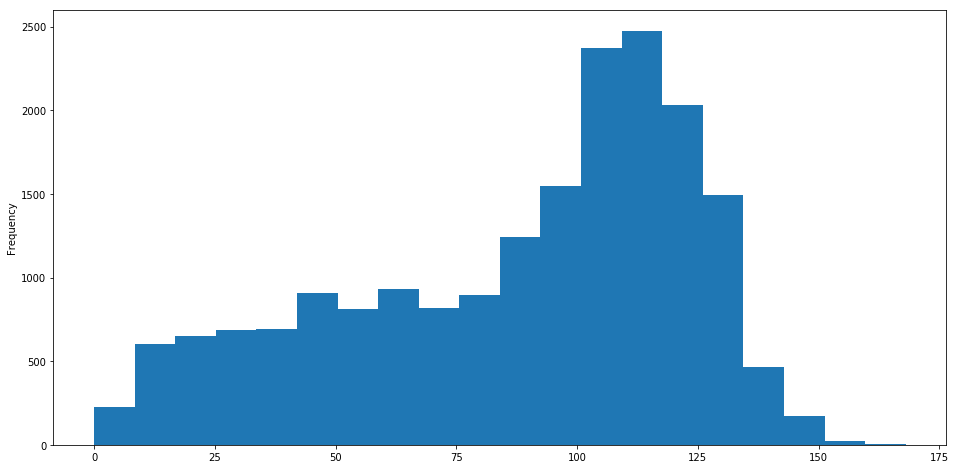

In [53]:
dataset.length.plot(bins=20, kind='hist', figsize=(16, 8))

In [54]:
dataset.length.describe()

count    19044.000000
mean        87.483197
std         35.882001
min          0.000000
25%         60.000000
50%         98.000000
75%        116.000000
max        168.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1133e1150>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10ff9de50>], dtype=object)

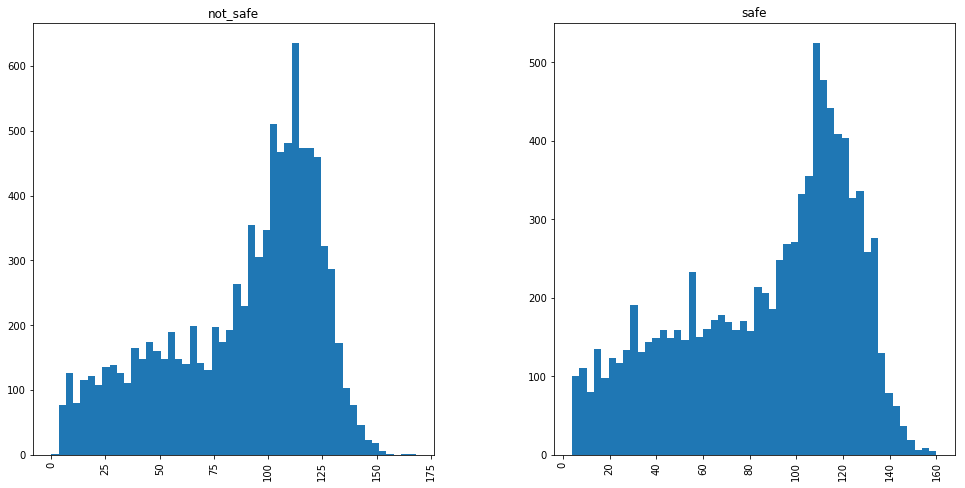

In [55]:
dataset.hist(column='length', by='label', bins=50, figsize=(16, 8))

In [56]:
def split_into_lemmas(message):
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [57]:
# not appropriate data, need training and test set
dataset = shuffle(dataset)

In [58]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(dataset['review'], dataset['label'], test_size=0.2)

print len(msg_train), len(msg_test), len(msg_train) + len(msg_test)

15235 3809 19044


In [59]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [60]:
# Cross-validation is a technique for evaluating ML models by training several 
# ML models on subsets of the available input data and
# evaluating them on the complementary subset of the data
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print scores

[ 0.85180328  0.85104987  0.82939633  0.84120735  0.84766907  0.84832567
  0.83913329  0.82862771  0.84438608  0.86145765]


In [61]:
print scores.mean(), scores.std()

0.844305629672 0.00963228047582


In [62]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas,),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)
%time nb_detector = grid.fit(msg_train, label_train)

CPU times: user 9.44 s, sys: 447 ms, total: 9.89 s
Wall time: 53.3 s


In [63]:
def print_top10(vectorizer, clf):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    #for i, class_label in enumerate(class_labels):
    print np.argsort(clf.coef_[0])
    top10 = np.argsort(clf.coef_[0])[-10:]
    bot10 = np.argsort(clf.coef_[0])[0:10]
    print("%s" % (" ".join(feature_names[j] for j in top10)))
    print("%s" % (" ".join(feature_names[j] for j in bot10)))


#print nb_detector.grid_scores_
best =nb_detector.best_estimator_
print_top10(best.named_steps['bow'], best.named_steps['classifier'])

[   0 3838 3839 ..., 4117 4142 5605]
delicious used very good loved these great made make recipe
a lackluster lactaid ladle ladlefull ladling ladyfinger laguna laid lake


In [64]:
predictions = nb_detector.predict(msg_test)
prob = nb_detector.predict_proba(msg_test)

['not_safe' 'not_safe' 'not_safe' ..., 'safe' 'not_safe' 'safe']
[[ 0.7386711   0.2613289 ]
 [ 0.85728248  0.14271752]
 [ 0.60028873  0.39971127]
 ..., 
 [ 0.19761653  0.80238347]
 [ 0.71975231  0.28024769]
 [ 0.22959779  0.77040221]]


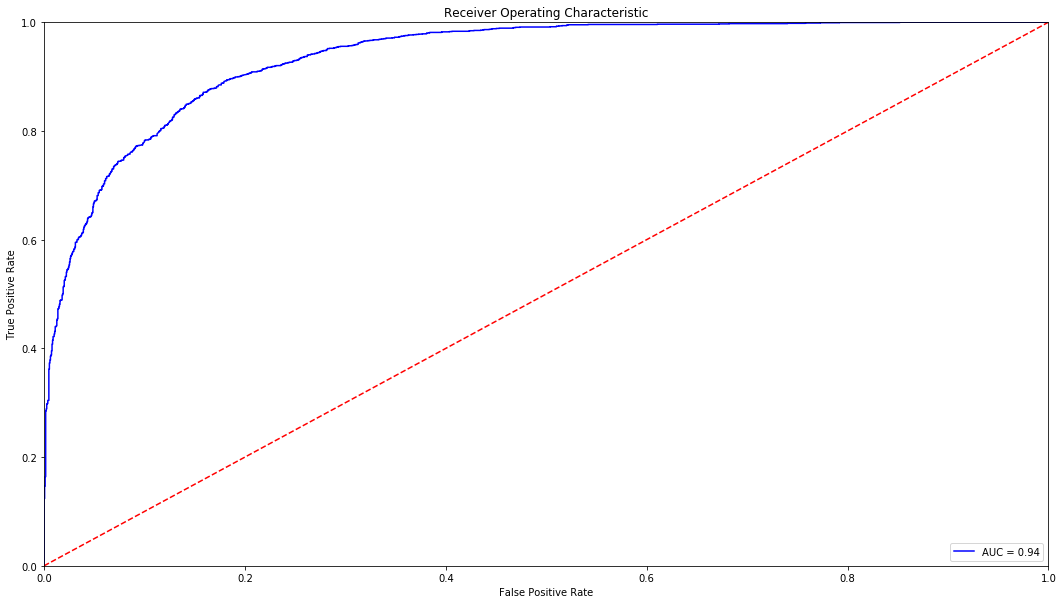

In [65]:
print predictions
print prob
ytest = [1 if x == "safe" else 0 for x in label_test ]
fpr, tpr, _ = roc_curve(ytest, prob[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(18,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


[[1647  269]
 [ 287 1606]]


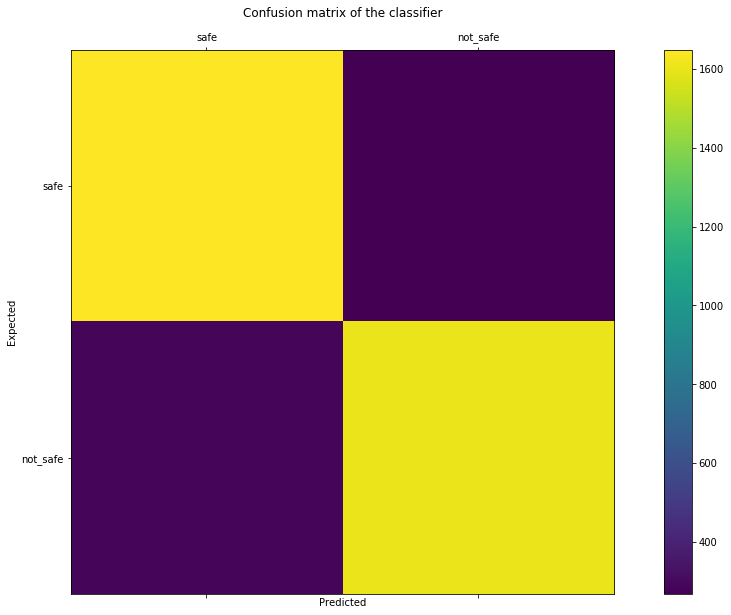

In [66]:
labels=["safe", "not_safe"]
cm = confusion_matrix(label_test, predictions, labels)
print cm
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
pl.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
pl.xlabel('Predicted')
pl.ylabel('Expected')
pl.show()

In [67]:
print classification_report(label_test, predictions)

             precision    recall  f1-score   support

   not_safe       0.86      0.85      0.85      1893
       safe       0.85      0.86      0.86      1916

avg / total       0.85      0.85      0.85      3809

